# State estimation

Run an Iterated Extended Kalman Filter and RTS smoother on the assignment data.

## Initialize

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import random
from pathlib import Path

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from system_identification.iekf import IteratedExtendedKalmanFilter
from system_identification.load_assignment_data import load_assignment_data

In [3]:
u, v, w, cau = sp.symbols("u, v, w, C_alpha_u")
alpha_m, beta_m, v_m = sp.symbols("alpha_m, beta_m, V_m")
u_dot, v_dot, w_dot = sp.symbols("udot, vdot, wdot")

## Filtering and smoothing
Define a iterated extended Kalman filter with an RTS smoother to pre-process the measured data.

In [4]:
# Define filter/smoother
iekf = IteratedExtendedKalmanFilter(
    x=[u, v, w, cau],
    z=[alpha_m, beta_m, v_m],
    u=[u_dot, v_dot, w_dot],
    f=sp.Matrix([
        u_dot,
        v_dot,
        w_dot,
        0.
    ]),
    h=sp.Matrix([
        sp.atan(w / u) * (1 + cau),
        sp.atan(v / sp.sqrt(u**2 + w**2)),
        sp.sqrt(u**2 + v**2 + w**2)
    ]),
    g=sp.Matrix(np.diag([1, 1, 1, 0])),
    max_iterations=10,
    eps=1e-10,
)
iekf

$$x = \left( u, \  v, \  w, \  C_{\alpha u}\right)$$  
$$z = \left( \alpha_{m}, \  \beta_{m}, \  V_{m}\right)$$  
$$u = \left( \dot{u}, \  \dot{v}, \  \dot{w}\right)$$  
$$f(\dots) = \left[\begin{matrix}\dot{u}\\\dot{v}\\\dot{w}\\0\end{matrix}\right]$$  
$$g(\dots) = \left[\begin{matrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 0\end{matrix}\right]$$  
$$h(\dots) = \left[\begin{matrix}\left(C_{\alpha u} + 1\right) \operatorname{atan}{\left(\frac{w}{u} \right)}\\\operatorname{atan}{\left(\frac{v}{\sqrt{u^{2} + w^{2}}} \right)}\\\sqrt{u^{2} + v^{2} + w^{2}}\end{matrix}\right]$$  
$$F_x(\dots) = \left[\begin{matrix}0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\\0 & 0 & 0 & 0\end{matrix}\right]$$  
$$H_x(\dots) = \left[\begin{matrix}- \frac{w \left(C_{\alpha u} + 1\right)}{u^{2} \cdot \left(1 + \frac{w^{2}}{u^{2}}\right)} & 0 & \frac{C_{\alpha u} + 1}{u \left(1 + \frac{w^{2}}{u^{2}}\right)} & \operatorname{atan}{\left(\frac{w}{u} \right)}\\- \frac{u v}{\left(u^{2} + w^{2}\right)^{\frac{3}{2}} \left(\frac{v^{2}}{u^{2} + w^{2}} + 1\right)} & \frac{1}{\sqrt{u^{2} + w^{2}} \left(\frac{v^{2}}{u^{2} + w^{2}} + 1\right)} & - \frac{v w}{\left(u^{2} + w^{2}\right)^{\frac{3}{2}} \left(\frac{v^{2}}{u^{2} + w^{2}} + 1\right)} & 0\\\frac{u}{\sqrt{u^{2} + v^{2} + w^{2}}} & \frac{v}{\sqrt{u^{2} + v^{2} + w^{2}}} & \frac{w}{\sqrt{u^{2} + v^{2} + w^{2}}} & 0\end{matrix}\right]$$

In [5]:
# Load data
data_dir_path = Path().cwd().parent / "assignment"
data = load_assignment_data(data_dir_path)
data

<xarray.Dataset>
Dimensions:  (t: 10001)
Coordinates:
  * t        (t) float64 0.0 0.01 0.02 0.03 0.04 ... 99.97 99.98 99.99 100.0
Data variables:
    alpha_m  (t) float64 -0.004572 -0.003229 -0.004428 ... -0.2303 -0.2288
    beta_m   (t) float64 0.002069 0.002634 0.0005577 ... 0.2579 0.2543 0.2574
    V_m      (t) float64 144.9 147.6 153.4 148.4 ... 152.3 152.1 152.1 153.9
    udot     (t) float64 1.043e-05 6.843e-06 4.02e-06 ... -2.244 -2.153 -2.05
    vdot     (t) float64 0.45 0.4499 0.4497 0.4494 ... 24.86 24.46 24.05 23.63
    wdot     (t) float64 2.855e-07 0.0225 0.04499 ... -49.15 -46.12 -43.07
    c_m      (t) float64 -0.05797 -0.05873 -0.05849 ... -0.03054 -0.02537

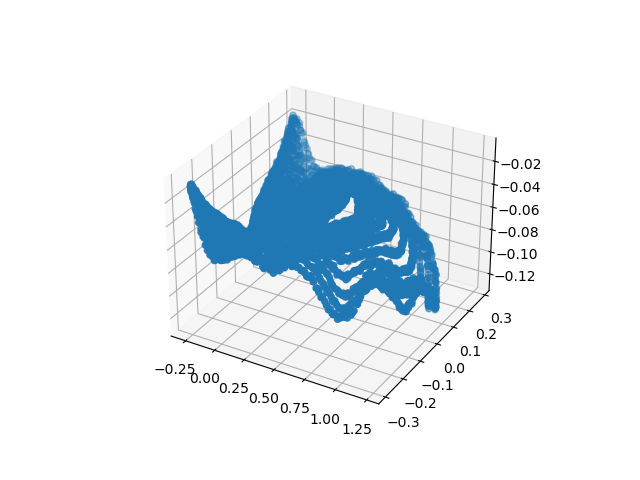

In [6]:
# plot data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data.alpha_m, data.beta_m, data.c_m)

In [7]:
# Run filter and smoother.
data = iekf.smooth(
    data=data.copy(),
    x_0=[
        data.V_m.sel(t=0),
        0,
        0,
        0.6
    ],
    p_0=np.diag([1., 1., 1., 1.]),
    q=np.diag([1e-3**2, 1e-3**2, 1e-3**2, 0.**2]),
    r=np.diag([0.01**2, 0.0058**2, 0.112**2]),
    verbose=True
)

  0%|          | 0/10000 [00:00<?, ?it/s, Filtering]

  0%|          | 0/10000 [00:00<?, ?it/s, Smoothing]

In [9]:
data

<xarray.Dataset>
Dimensions:                 (t: 10001, dim_0: 4, dim_1: 4, x_idx: 4)
Coordinates:
  * t                       (t) float64 0.0 0.01 0.02 0.03 ... 99.98 99.99 100.0
Dimensions without coordinates: dim_0, dim_1, x_idx
Data variables: (12/32)
    alpha_m                 (t) float64 -0.004572 -0.003229 ... -0.2303 -0.2288
    beta_m                  (t) float64 0.002069 0.002634 ... 0.2543 0.2574
    V_m                     (t) float64 144.9 147.6 153.4 ... 152.1 152.1 153.9
    udot                    (t) float64 1.043e-05 6.843e-06 ... -2.153 -2.05
    vdot                    (t) float64 0.45 0.4499 0.4497 ... 24.46 24.05 23.63
    wdot                    (t) float64 2.855e-07 0.0225 ... -46.12 -43.07
    ...                      ...
    v_smoothed              (t) float64 -0.08299 -0.07849 ... 38.2 38.44
    v_smoothed_std          (t) float64 4.304e-05 4.304e-05 ... 4.283e-05
    w_smoothed              (t) float64 -0.03776 -0.03776 ... -21.1 -21.56
    w_smoothed_std          (t) float64 1.918e-05 1.918e-05 ... 1.884e-05
    C_alpha_u_smoothed      (t) float64 0.6065 0.6065 0.6065 ... 0.6065 0.6065
    C_alpha_u_smoothed_std  (t) float64 1.453e-07 1.453e-07 ... 1.453e-07

In [10]:
# Calculate Vm from the filtered and smoothed signals
data["vm_filtered"] = \
    np.sqrt(
        np.square(data.u_filtered)
        + np.square(data.v_filtered)
        + np.square(data.w_filtered)
    )

data["vm_smoothed"] = \
    np.sqrt(
        np.square(data.u_smoothed)
        + np.square(data.v_smoothed)
        + np.square(data.w_smoothed)
)

# Calculate the estimated alpha
c_alpha_estimate = data.C_alpha_u_smoothed.values[0]
data['alpha_estimate'] = data.alpha_m / (1 + c_alpha_estimate)

### Plot results

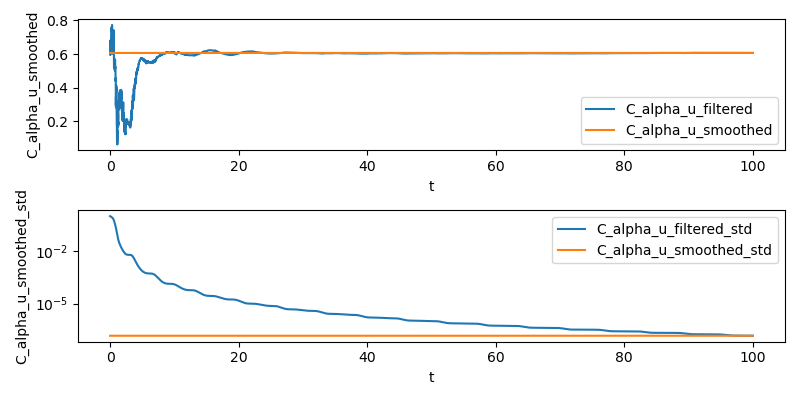

In [11]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 4))
data.C_alpha_u_filtered.plot.line(label="C_alpha_u_filtered", ax=ax1)
data.C_alpha_u_smoothed.plot.line(label="C_alpha_u_smoothed", ax=ax1)
ax1.legend()

data.C_alpha_u_filtered_std.plot.line(label="C_alpha_u_filtered_std", ax=ax2)
data.C_alpha_u_smoothed_std.plot.line(label="C_alpha_u_smoothed_std", ax=ax2)
ax2.set_yscale("log")
ax2.legend()
plt.tight_layout()

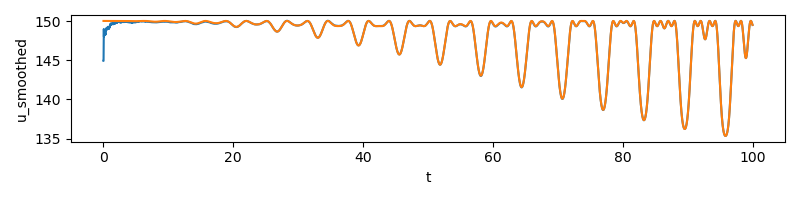

In [12]:
plt.figure(figsize=(8, 2))
data.u_filtered.plot()
data.u_smoothed.plot()
plt.tight_layout()

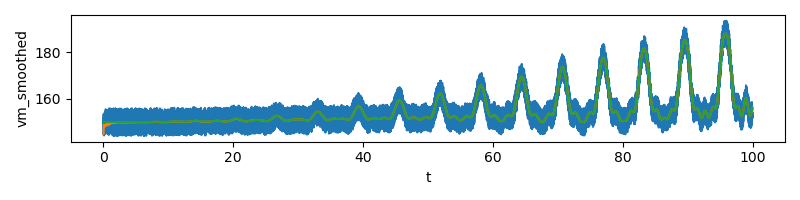

In [13]:
plt.figure(figsize=(8, 2))
data.V_m.plot()
data.vm_filtered.plot()
data.vm_smoothed.plot()
plt.tight_layout()

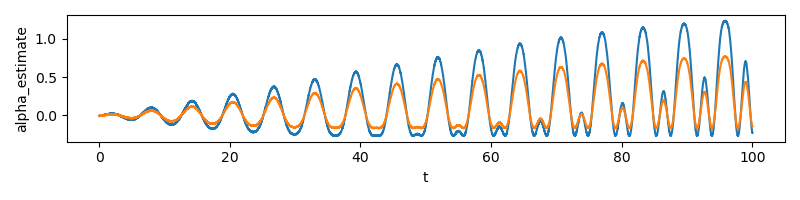

In [14]:
plt.figure(figsize=(8, 2))
data.alpha_m.plot()
data.alpha_estimate.plot()
plt.tight_layout()

## Training data
Select the data that will be used for training and validating the neural networks later in the assignemnt.

In [15]:
# Set containing the indices of all samples.
all_idxs = set(range(len(data.t)))

# Set containing indices of validation samples.
# This will contain roughly 30% of samples.
validation_idxs = set((
    *range(7_00, 15_00),  # 7->15s
    *range(20_00, 25_00),
    *range(59_00, 61_00),
    *range(66_00, 76_00),
    *range(85_00, 90_00),
))

# Select training samples. All excluding the validation samples.
# And transform the sets into sorted lists.
training_idxs = list(sorted(all_idxs - validation_idxs))
validation_idxs = list(sorted(validation_idxs))

print(f"Training: {len(training_idxs)/len(all_idxs)*100}%")
print(f"Validation: {len(validation_idxs)/len(all_idxs)*100}%")

Training: 70.00299970003%
Validation: 29.99700029997%


In [16]:
# Select the samples from the smoothed data and reshape
# such that they have shapes (n_samples, n_inputs, 1)
# (n_samples, n_outputs, 1)

training_inputs = np.vstack(
    (data.alpha_estimate.isel(t=training_idxs).values,
     data.beta_m.isel(t=training_idxs).values)).T[..., None]
training_outputs = data.c_m.isel(t=training_idxs).values.reshape((-1, 1, 1))

validation_inputs = np.vstack(
    (data.alpha_estimate.isel(t=validation_idxs).values,
     data.beta_m.isel(t=validation_idxs).values)).T[..., None]
validation_outputs = data.c_m.isel(t=validation_idxs).values.reshape((-1, 1, 1))

all_inputs = np.vstack(
    (data.alpha_estimate.values,
     data.beta_m.values)).T[..., None]
all_outputs = data.c_m.values.reshape((-1, 1, 1))

input_range = np.array([
    [min(data.alpha_estimate.values), max(data.alpha_estimate.values)],
    [min(data.beta_m.values), max(data.beta_m.values)]])

In [17]:
# Put training and validation data in the dataset.
data['input_range'] = (("d0", "d1"), input_range)
data['training_inputs'] = (("training_samples", "inputs", "m"), training_inputs)
data['training_outputs'] = (("training_samples", "outputs", "m"), training_outputs)
data['validation_inputs'] = (("validation_samples", "inputs", "m"), validation_inputs)
data['validation_outputs'] = (("validation_samples", "outputs", "m"), validation_outputs)
data['all_inputs'] = (("all_samples", "inputs", "m"), all_inputs)
data['all_outputs'] = (("all_samples", "outputs", "m"), all_outputs)
data

<xarray.Dataset>
Dimensions:                 (t: 10001, dim_0: 4, dim_1: 4, x_idx: 4, d0: 2,
                             d1: 2, training_samples: 7001, inputs: 2, m: 1,
                             outputs: 1, validation_samples: 3000,
                             all_samples: 10001)
Coordinates:
  * t                       (t) float64 0.0 0.01 0.02 0.03 ... 99.98 99.99 100.0
Dimensions without coordinates: dim_0, dim_1, x_idx, d0, d1, training_samples,
                                inputs, m, outputs, validation_samples,
                                all_samples
Data variables: (12/42)
    alpha_m                 (t) float64 -0.004572 -0.003229 ... -0.2303 -0.2288
    beta_m                  (t) float64 0.002069 0.002634 ... 0.2543 0.2574
    V_m                     (t) float64 144.9 147.6 153.4 ... 152.1 152.1 153.9
    udot                    (t) float64 1.043e-05 6.843e-06 ... -2.153 -2.05
    vdot                    (t) float64 0.45 0.4499 0.4497 ... 24.46 24.05 23.63
    wdot                    (t) float64 2.855e-07 0.0225 ... -46.12 -43.07
    ...                      ...
    training_inputs         (training_samples, inputs, m) float64 -0.002846 ....
    training_outputs        (training_samples, outputs, m) float64 -0.05797 ....
    validation_inputs       (validation_samples, inputs, m) float64 0.03444 ....
    validation_outputs      (validation_samples, outputs, m) float64 -0.0569 ...
    all_inputs              (all_samples, inputs, m) float64 -0.002846 ... 0....
    all_outputs             (all_samples, outputs, m) float64 -0.05797 ... -0...

## Save data

In [18]:
data.to_netcdf("data/data_smoothed.nc")